<a href="https://colab.research.google.com/github/ramon-santana-silva/ML_NaoSupervisonado/blob/main/Clustering_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contextualization

![](https://github.com/cmcouto-silva/figures/blob/main/ML_diagram_clustering.png?raw=true)

**Aprendizado não-supervisionado (unsupervised learning)**

No aprendizado não supervisionado, do qual **clustering** faz parte, **não há variável resposta**, e entre seus objetivos estão o tratamento, exploração e diagnóstico dos dados (exemplo: encontrar padrões).

**Exemplos:**
- **Clustering:** identificar e agrupar observações similares.
- **Dimensionality reduction:** reduzir a quantidade de dimensões (variáveis).

**Quantos algoritmos não-supervisionados temos?**

- Clustering: [https://scikit-learn.org/stable/modules/clustering.html](https://scikit-learn.org/stable/modules/clustering.html)
- Dimentionality reduction: [https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition)

**Classifique como tarefa supervisionada ou não-supervisionada:**

1. Segmentação de clientes para entendermos melhor diferentes perfis: ________
2. Classificação de clientes em churn e não-churn: ________
3. Agrupamento de produtos similares entre si: ________
4. Redução da dimensionalidade dos dados: ________
5. Previsão da probabilidade de um cliente contratar o serviço: ________

<details>
  <summary><b>Respostas</b></summary>
  <ol type="1">
  <li><b>unsupervised learning</b></li>
  <li>supervised learning</li>
  <li><b>unsupervised learning</b></li>
  <li><b>unsupervised learning</b></li>
  <li>supervised learning</li>
  </ol>
</details>


# Setup

In [ ]:
!pip install prince
!pip install kmodes

In [ ]:
# Data wrangling
import re
import glob
import numpy as np
import pandas as pd

# Dataviz
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from yellowbrick.cluster import kelbow_visualizer
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

## -- Machine learning -- ##
from sklearn import datasets
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering
from sklearn.cluster import k_means, dbscan, mean_shift, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, minmax_scale, MinMaxScaler

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

import prince                               # factor analysis (including categorical data)
from kmodes.kmodes import KModes            # clustering categorical data
from kmodes.kprototypes import KPrototypes  # clustering mixed data

# Didatic purposes
import string
from ipywidgets import interact

In [ ]:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='bright',
    rc={
        'figure.figsize': (11,6),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

scatter_kwargs = dict(palette='viridis', alpha=0.8, linewidth=0)

# K-means

App de simulação:
- [Versão em português (streamlit)](https://cmcouto-silva-kmeans-app-pt-streamlit-app-tyl62y.streamlitapp.com/)
- ~[Versão em português (dash)](https://kmeans-animation-pt.herokuapp.com/)~
- [Versão em inglês](https://cmcouto-silva-kmeans-app-en-streamlit-app-v886a2.streamlitapp.com/)

**Requerimentos:**
- Dados numéricos contínuos
- Dados na mesma escala
- Pré-determinação do número de grupos (k)

**Vantagens:**
- Simples
- Eficiente
- Escalável para uma grande quantidade de dados

**Desvantagens:**
- Sensível a outliers
- Pré-determinação do número de grupos (k)
- Não adequado para dados categóricos (mesmo com one-hot encoding)
- Não adequado para dados com estrutura complexa e não-linear.

Fontes:
- [https://www.ibm.com/support/pages/clustering-binary-data-k-means-should-be-avoided](https://www.ibm.com/support/pages/clustering-binary-data-k-means-should-be-avoided)
- Livro: Practical Statistics for Data Scientists (Peter Bruce et al., 2020)
- Statistical foruns

## Simulated Data

In [ ]:
# Simulate clusters
X,y = datasets.make_blobs(n_samples=int(5E3), n_features=2, centers=4, cluster_std=.8, random_state=0)
df = pd.DataFrame(X, columns=list(string.ascii_uppercase[:X.shape[1]]))
df.head()

,A,B
0,1.998996,1.535900
1,-2.788784,2.773154
2,-0.956255,3.630438
3,2.777738,-1.508286
4,0.982364,5.013279


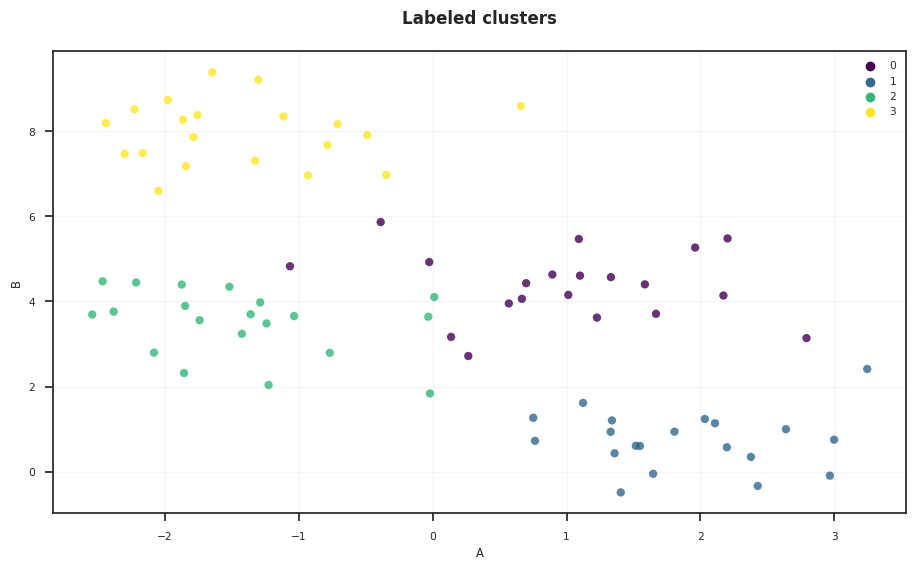

In [ ]:
# Visualize simulated clusters
sns.scatterplot(data=df, x='A', y='B', hue=y, **scatter_kwargs)
plt.title('Labeled clusters')
plt.show()

## Distinct APIs for K-means

No sklearn, podemos utilizar algoritmos de clusterização através de classes ou funções (vide [este link](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster)).

In [ ]:
# Usando função
centroids, labels, inertia = k_means(X, n_clusters=2, random_state=0)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Using KMeans
model = KMeans(n_clusters=2, random_state=0)
model.fit(X)

centroids = model.cluster_centers_
labels = model.labels_
intertia = model.inertia_

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Model evaluation

Uma boa clusterização vai produzir:
- Alta similaridade intra-cluster
- Pouca similaridade entre clusters

Métricas:
- Inércia
- Silhouette
- Davies Bouldin (`intracluster / intercluster`)
- Calinski Harabasz (`soma_intercluster / soma_intracluster`)

Exemplo de aplicação:

In [ ]:
print(
  silhouette_score(X, labels),
  davies_bouldin_score(X, labels),
  calinski_harabasz_score(X, labels),
  sep='\n'
)

0.515911480826198
0.6225299776282515
6401.924184343904


Testando distintos agrupamentos:

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

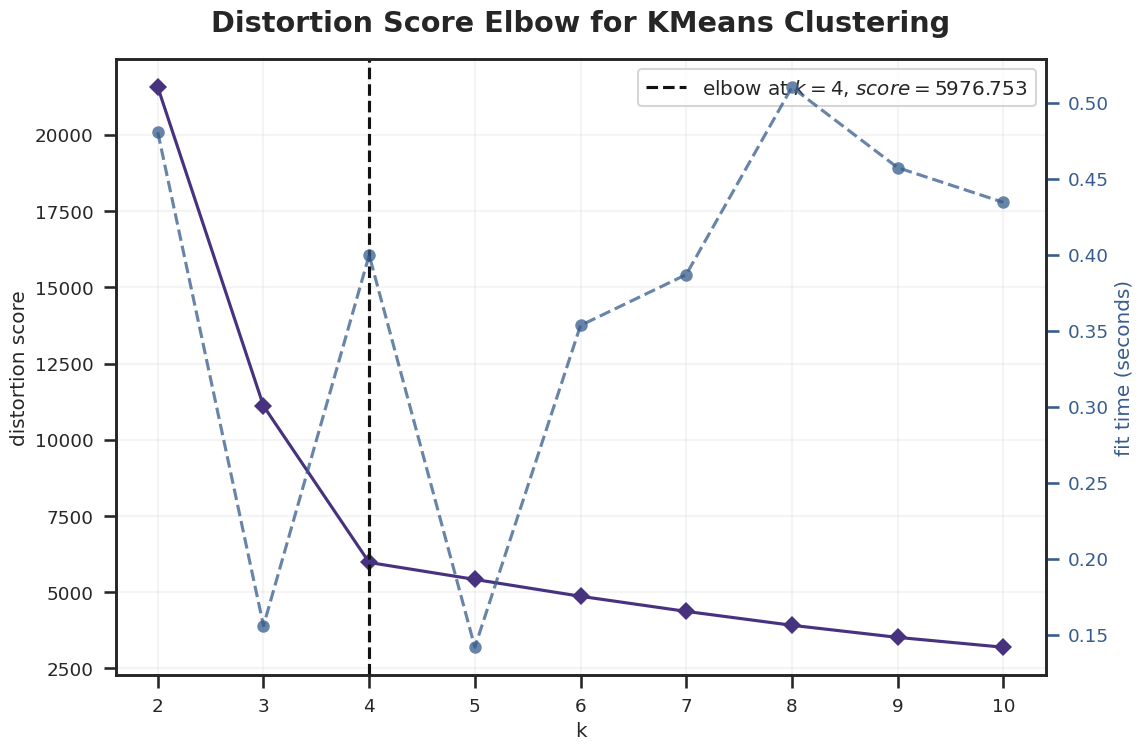

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(2,11))
visualizer.fit(X).show()

In [ ]:
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []

for k in range(2,11):
  model = KMeans(n_clusters=k, random_state=0)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k':k}
  cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

In [ ]:
pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient(cmap='Blues')

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,21560.408252,0.515911,0.622530,6401.924184
3,11109.654785,0.524957,0.707935,8561.144307
4,5976.759031,0.578246,0.585966,12037.104646
5,5420.318913,0.493568,0.824047,10080.863421
6,4868.312284,0.429343,0.982976,9091.901722
7,4372.174929,0.337104,1.128953,8528.016069
8,3917.117225,0.315862,1.175141,8240.152861
9,3520.796889,0.319956,1.089390,8090.919608
10,3197.647190,0.325477,1.010998,7972.906967


In [ ]:
(
  pd.DataFrame(cluster_metrics_results)
  .set_index('k').style.background_gradient(cmap='Oranges', subset='inertia')
  .highlight_max(subset='silhouette_score')
  .highlight_min(subset='davies_bouldin_score')
)

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,21560.408252,0.515911,0.622530,6401.924184
3,11109.654785,0.524957,0.707935,8561.144307
4,5976.759031,0.578246,0.585966,12037.104646
5,5420.318913,0.493568,0.824047,10080.863421
6,4868.312284,0.429343,0.982976,9091.901722
7,4372.174929,0.337104,1.128953,8528.016069
8,3917.117225,0.315862,1.175141,8240.152861
9,3520.796889,0.319956,1.089390,8090.919608
10,3197.647190,0.325477,1.010998,7972.906967


Repetindo procedimento acima com dados simulados aleatórios:

In [ ]:
X_random = np.random.rand(*X.shape)

In [ ]:
cluster_metrics = silhouette_score, davies_bouldin_score
cluster_metrics_results = []

for k in range(2,11):
  model = KMeans(n_clusters=k, random_state=0)
  labels = model.fit_predict(X_random)
  cluster_results_dict = {'k':k}
  cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

In [ ]:
pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient(cmap='Greys')

,inertia,silhouette_score,davies_bouldin_score
k,,,
2,518.445447,-0.000073,74.284792
3,331.132705,-0.008467,55.706929
4,210.030055,-0.013825,119.510754
5,176.016488,-0.016308,84.651602
6,149.581099,-0.021741,74.188604
7,127.174490,-0.022127,76.928444
8,108.076182,-0.023073,126.537655
9,92.540539,-0.031983,84.487842
10,85.009800,-0.032427,134.726309


Comparando de forma interativa:

In [ ]:
@interact(k=(2,11), data=['X','X_random'])
def plot_kmeans(k, data):
  data = X if data=='X' else X_random
  model = KMeans(n_clusters=k, random_state=0)
  labels = model.fit_predict(data)
  sns.scatterplot(x=data[:,0], y=data[:,1], hue=labels, **scatter_kwargs)
  plt.show()

interactive(children=(IntSlider(value=6, description='k', max=11, min=2), Dropdown(description='data', options…

## High dimensional data

In [ ]:
# Simulate clusters with high dimensional data
X_dim,y_dim = datasets.make_blobs(n_samples=int(1E3), n_features=10, centers=4, cluster_std=.8, random_state=0)
df_dim = pd.DataFrame(X_dim, columns=list(string.ascii_uppercase[:X_dim.shape[1]]))
df_dim.head()

,A,B,C,D,E,F,G,H,I,J
0,1.375988,3.328840,2.252246,0.163276,-2.048389,1.498086,-1.626945,7.672603,9.713141,-2.330450
1,-4.778629,5.591210,-0.834382,0.333095,-10.125881,3.179277,2.914841,1.443623,9.603470,5.607201
2,11.184614,5.196295,-0.802285,5.042595,-7.432989,3.606461,-7.730530,8.711666,1.110940,-1.709037
3,9.696156,5.280882,-1.214031,4.589872,-8.312332,3.070013,-6.423507,9.210979,1.207334,-1.770543
4,-4.262755,4.842532,-0.878987,1.944770,-8.669946,2.534408,2.236930,0.444544,8.682765,3.178775


In [ ]:
pca = PCA()
pca_components = pca.fit_transform(df_dim)
df_pca = pd.DataFrame(pca_components, columns=[f'PC{i+1}' for i in range(df_dim.shape[1])])
display(df_pca)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-5.856883,3.122523,6.136654,-0.686487,0.347968,-0.618029,-0.467717,-0.505754,-0.563464,0.814840
1,-11.436590,-6.559320,-4.410817,-1.239685,-0.029943,1.017996,0.895097,-0.878642,-0.584850,-0.537870
2,6.443283,9.334398,-3.091811,-1.298623,-0.771382,0.358402,0.372171,-0.301598,-1.050753,0.198899
3,5.114664,8.403564,-3.589742,-1.178399,-0.325189,-0.178110,-0.224107,-0.534450,0.190508,0.744221
4,-10.328252,-5.222973,-3.462066,0.586746,-0.655750,1.066886,-0.717080,0.606951,-1.759044,0.041215
...,...,...,...,...,...,...,...,...,...,...
995,-6.590360,3.422836,6.599212,-1.688134,0.281325,0.597289,0.406577,0.046039,0.643861,-0.928400
996,-7.330300,3.541334,4.587332,0.810124,1.054155,-1.566163,-0.340734,-0.499334,-1.155100,-0.353791
997,-6.411780,5.056657,5.401471,0.665292,0.160854,-0.069270,-0.404070,0.207449,0.184674,0.605232
998,-9.947851,-4.739351,-3.272195,0.732262,-0.496340,-0.558349,-0.108244,0.305074,-0.048046,-0.388834


In [ ]:
pca.explained_variance_ratio_.cumsum()

array([0.55329463, 0.86083646, 0.96928936, 0.97418833, 0.97895301,
       0.98346233, 0.98785112, 0.99213323, 0.99621909, 1.        ])

In [ ]:
pd.DataFrame(
    {'explained_var': pca.explained_variance_ratio_, 'explained_var_cumsum': pca.explained_variance_ratio_.cumsum()},
    index=df_pca.columns
).style.format('{:.2%}')

,explained_var,explained_var_cumsum
PC1,55.33%,55.33%
PC2,30.75%,86.08%
PC3,10.85%,96.93%
PC4,0.49%,97.42%
PC5,0.48%,97.90%
PC6,0.45%,98.35%
PC7,0.44%,98.79%
PC8,0.43%,99.21%
PC9,0.41%,99.62%
PC10,0.38%,100.00%


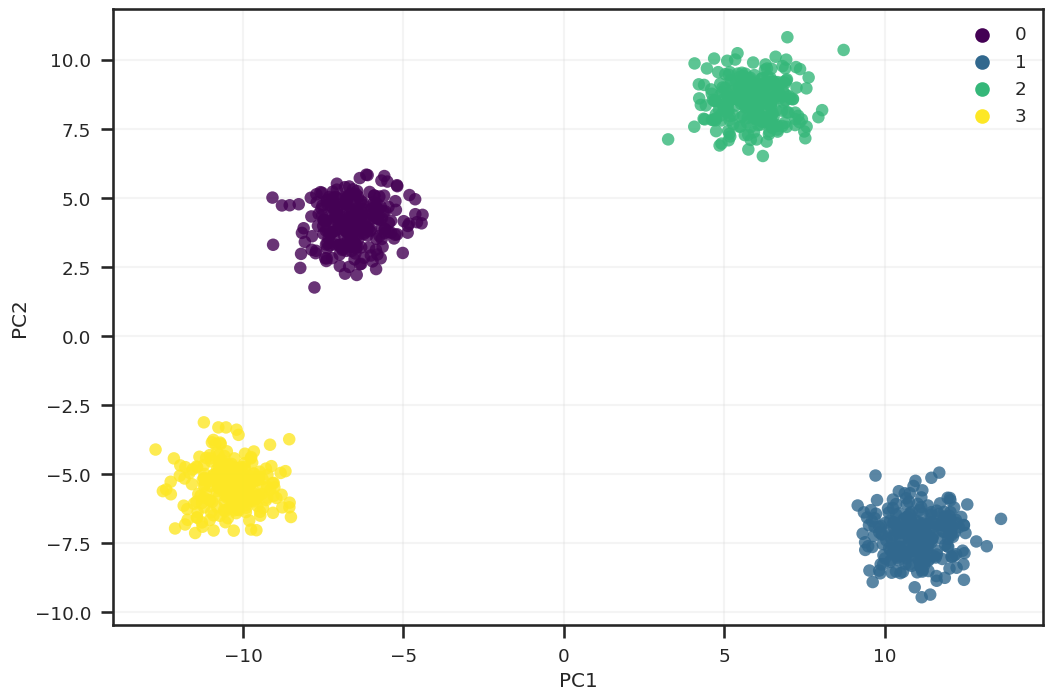

In [ ]:
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue=y_dim, **scatter_kwargs);

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



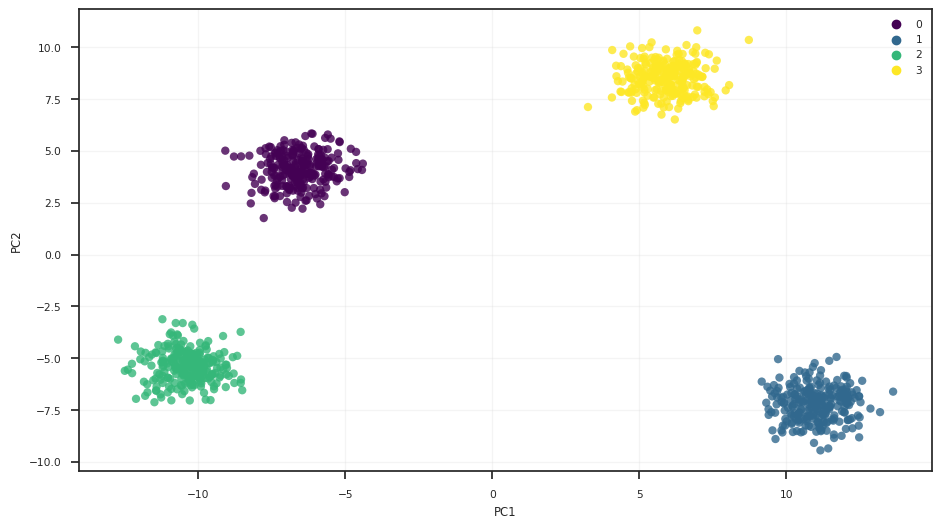

In [ ]:
labels = k_means(df_pca, 4)[1]
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue=labels, **scatter_kwargs);

In [ ]:
px.scatter_3d(data_frame=df_pca, x='PC1', y='PC2', z='PC3', color=labels.astype(str), template='plotly_dark')

# Hierarchical clustering

**Tipos:**
- Agglomerative (bottom-up)
- Dissimilarity (top-down)

**Vantagens:**
- Fácil interpretação
- Não é necessário estabelecer a quantidade de grupos previamente
- Pode ser usada com diferentes métodos de agrupamento e critérios de distância.

**Desvantagens:**
- Não escala bem com muitos dados
- Sensível ao método e métrica de distância selecionados
- Dendograma fica com visualização inviável para muitas amostras
 

In [ ]:
# Simulate clusters
X,y = datasets.make_blobs(n_samples=80, n_features=2, centers=4, cluster_std=.8, random_state=0)
df = pd.DataFrame(X, columns=list(string.ascii_uppercase[:X.shape[1]]))
df.head()

,A,B
0,-1.864189,8.266859
1,-0.020383,1.839675
2,-1.114917,8.343485
3,2.427797,-0.331331
4,-1.288313,3.978991


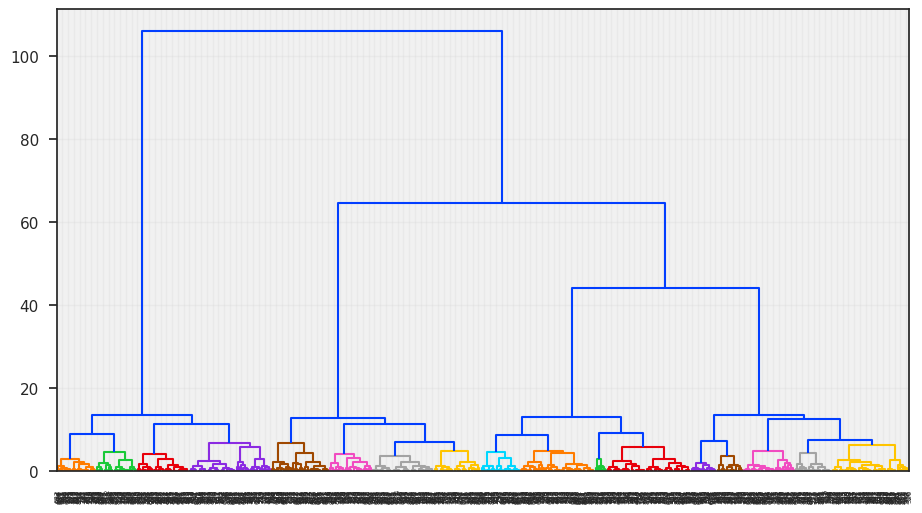

In [ ]:
Z = linkage(df, method='ward')
dendrogram_dict = dendrogram(Z, color_threshold=7)
plt.show()

In [ ]:
fcluster(Z, 4, criterion='maxclust')

array([1, 4, 1, 2, 4, 4, 2, 4, 1, 2, 1, 4, 2, 3, 1, 4, 2, 3, 4, 3, 2, 4,
       4, 2, 4, 1, 1, 4, 1, 1, 1, 4, 3, 4, 4, 4, 4, 3, 2, 1, 2, 2, 3, 4,
       1, 2, 3, 2, 4, 1, 2, 3, 3, 4, 3, 4, 3, 3, 1, 2, 3, 1, 1, 2, 2, 2,
       2, 3, 4, 1, 2, 2, 1, 4, 4, 3, 1, 1, 3, 2], dtype=int32)

# MeanShift

**Vantagens:**
- Possui apenas um parâmetro principal (bandwidth)
- Não necessita especificar a quantidade de clusters (também pode ser desvantagem)

**Desvantagens:**
- Computacionalmente custoso com grande volume de dados
- O resultado pode ser sensível ao valor de banda escolhido
- A escolha de um bom valor de banda pode ser difícil em algumas situações

In [ ]:
# Simulate clusters
X,y = datasets.make_blobs(n_samples=int(1E3), n_features=2, centers=4, cluster_std=.8, random_state=0)
df = pd.DataFrame(X, columns=list(string.ascii_uppercase[:X.shape[1]]))
df.head()

,A,B
0,-2.256086,7.858356
1,0.568548,3.953328
2,-2.602152,8.418937
3,-2.625338,2.063689
4,2.286564,1.227960


In [ ]:
estimate_bandwidth(X)

2.822735629625506

In [ ]:
model = MeanShift(n_jobs=-1)
model.fit(X)

MeanShift(n_jobs=-1)

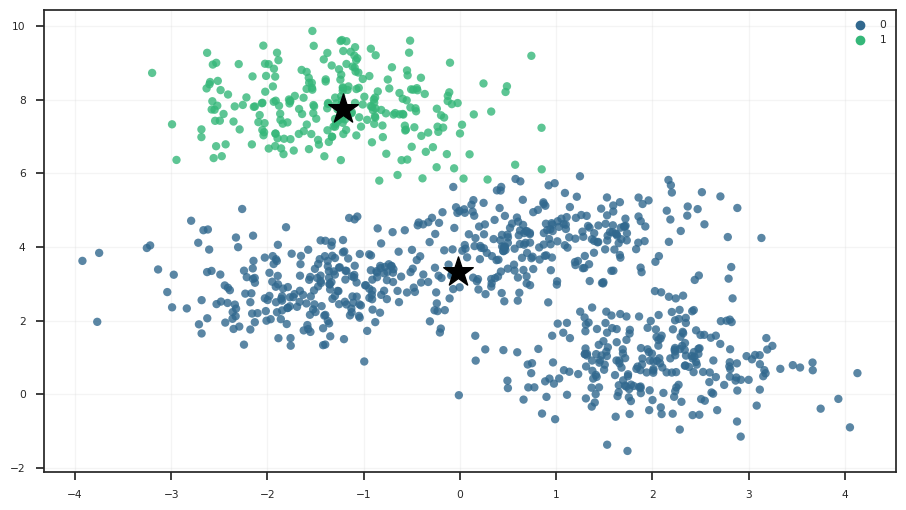

In [ ]:
labels = model.predict(X)
ax = sns.scatterplot(x=X[:,0], y=X[:,1], hue=labels, **scatter_kwargs)
ax.scatter(*model.cluster_centers_.T, marker='*', s=500, color='black')

In [ ]:
print(silhouette_score(X, labels))
print(davies_bouldin_score(X, labels))

0.5324827970890266
0.5812242300026665


In [ ]:
@interact(bandwidth=(0.1, 3, 0.01))
def custom_meanshift(bandwidth):
  model = MeanShift(bandwidth=bandwidth, n_jobs=-1).fit(X)
  labels = model.predict(X)
  ax = sns.scatterplot(x=X[:,0], y=X[:,1], hue=labels, **scatter_kwargs)
  ax.scatter(*model.cluster_centers_.T, marker='*', s=500, color='black')
  plt.show()

interactive(children=(FloatSlider(value=1.55, description='bandwidth', max=3.0, min=0.1, step=0.01), Output())…

# DBSCAN

**Requisitos:**
- Especificar o raio mínimo de um cluster
- Especificar a quantidade mínima de pontos para formar uma cluster

**Vantagens:**
- Detecta clusters de formatos variados (densos)
- Não necessita especificar a quantidade de clusters
- Robusto aos outliers e distribuições não uniformes

**Desvantagens:**
- É sensível à densidade dos dados
- A escolha dos parâmetros pode ser difícil em algumas situações
- Não funciona bem em clusters com densidades diferentes (OPTICS)

In [ ]:
# Simulate clusters
X,y = datasets.make_blobs(n_samples=int(5E3), n_features=2, centers=4, cluster_std=.8, random_state=0)
df = pd.DataFrame(X, columns=list(string.ascii_uppercase[:X.shape[1]]))
df.head()

,A,B
0,1.998996,1.535900
1,-2.788784,2.773154
2,-0.956255,3.630438
3,2.777738,-1.508286
4,0.982364,5.013279


In [ ]:
# Train DBSCAN
model = DBSCAN()
labels = model.fit_predict(X)

In [ ]:
# Train DBSCAN (function)
labels = dbscan(X)[1]

In [ ]:
@interact(eps=(0.01, 1, 0.01), min_samples=(1,20))
def custom_dbscan(eps, min_samples):
  _,labels = dbscan(X, eps=eps, min_samples=min_samples)
  sns.scatterplot(x=X[:,0], y=X[:,1], hue=labels, **scatter_kwargs)
  plt.show()

interactive(children=(FloatSlider(value=0.5, description='eps', max=1.0, min=0.01, step=0.01), IntSlider(value…

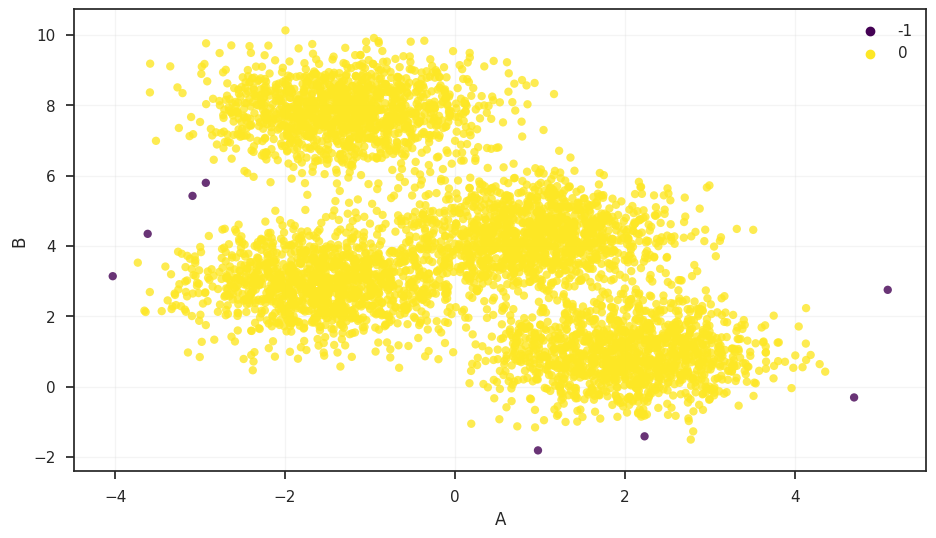

In [ ]:
# Visualize output
sns.scatterplot(data=df, x='A', y='B', hue=labels, **scatter_kwargs);

In [ ]:
@interact(eps=(0.01,1, 0.01), min_samples=(1,20))
def custom_dbscan(eps, min_samples):
  _, labels = dbscan(X, eps=eps, min_samples=min_samples)
  sns.scatterplot(data=df, x='A', y='B', hue=labels, palette='tab10')
  plt.show()

interactive(children=(FloatSlider(value=0.5, description='eps', max=1.0, min=0.01, step=0.01), IntSlider(value…

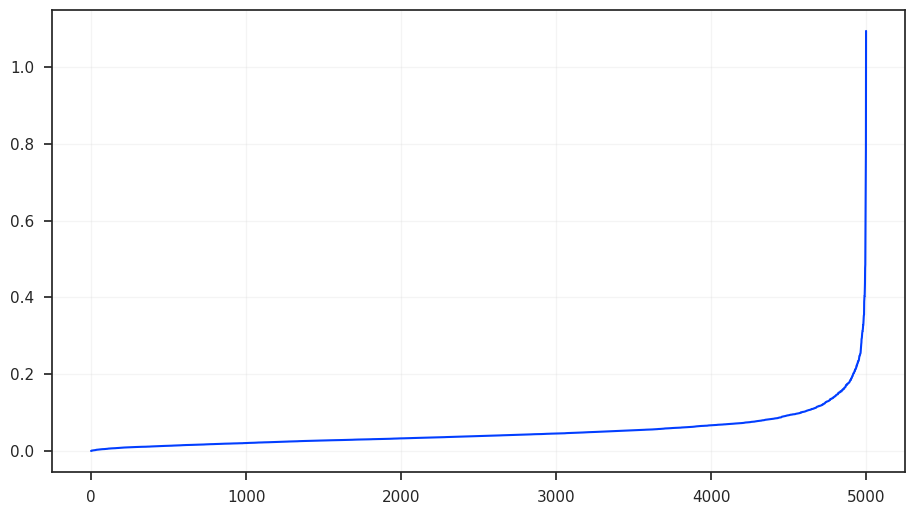

In [ ]:
# https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
from sklearn.neighbors import NearestNeighbors
nn_model = NearestNeighbors(n_neighbors=2).fit(X)
distances, indices = nn_model.kneighbors(X)
distances = np.sort(distances, axis=0)
plt.plot(distances[:,1])
plt.show()

# GMM

**Requisitos:**

- Definir o número de componentes gaussianos (centroides) a serem usados
- Escolher um método para estimar os parâmetros das distribuições gaussianas

**Vantagens:**

- É capaz de lidar com diferentes formas de clusters e tamanhos de cluster;
- Fornece uma distribuição probabilística sobre os dados em vez de simplesmente rotulá-los como pertencentes a um cluster.

**Desvantagens:**

- Sensível a outliers
- Requer estimativa de parâmetros para cada componente gaussiano
- Pode ser computacionalmente caro para grandes conjuntos de dados

In [ ]:
# Simulate clusters
X,y = datasets.make_blobs(n_samples=int(1E3), n_features=2, centers=4, cluster_std=.8, random_state=0)
df = pd.DataFrame(X, columns=list(string.ascii_uppercase[:X.shape[1]]))
df.head()

,A,B
0,-2.256086,7.858356
1,0.568548,3.953328
2,-2.602152,8.418937
3,-2.625338,2.063689
4,2.286564,1.227960


In [ ]:
# Create model
model = GaussianMixture(n_components=4, covariance_type='spherical')
model.fit(X)

GaussianMixture(covariance_type='spherical', n_components=4)

In [ ]:
# Model attributes
model.means_
model.covariances_
model.weights_

array([0.25115465, 0.24989313, 0.24923426, 0.24971796])

In [ ]:
# Predict labels
model.predict(X)[:5]

array([1, 0, 1, 2, 3])

In [ ]:
# Predict probability
model.predict_proba(X)[:5].round(2)

array([[0.  , 1.  , 0.  , 0.  ],
       [0.98, 0.  , 0.02, 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  ]])

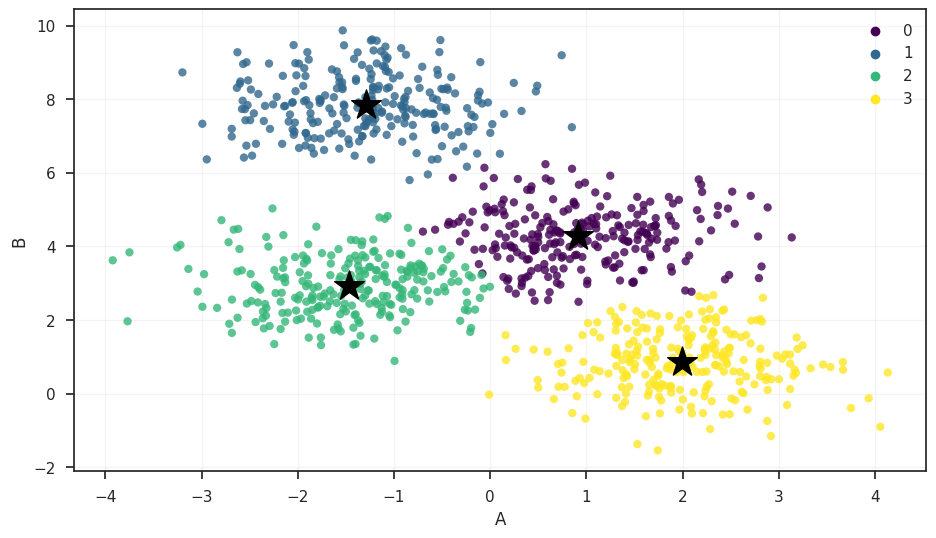

In [ ]:
# Plot
labels = model.predict(X)
ax = sns.scatterplot(data=df, x='A', y='B', hue=labels, **scatter_kwargs)
ax.scatter(*model.means_.T, marker='*', color='black', s=500);

In [ ]:
# Select best model by covariance type and K (Practical Statistics for Data Scientists)
results = []
k_range = range(2,11)
covariance_types = ['full', 'tied', 'diag', 'spherical']

for n_components in k_range:
  for covariance_type in covariance_types:
    mclust = GaussianMixture(n_components=n_components, warm_start=True, covariance_type=covariance_type)
    mclust.fit(X)
    results.append({
      'bic': mclust.bic(X),
      'n_components': n_components,
      'covariance_type': covariance_type,
    })

results = pd.DataFrame(results)
results

,bic,n_components,covariance_type
0,7976.527656,2,full
1,8165.511057,2,tied
2,8050.082533,2,diag
3,8036.917677,2,spherical
4,7526.427331,3,full
5,7736.189981,3,tied
6,7656.896132,3,diag
7,7666.916227,3,spherical
8,7475.928562,4,full
9,7419.261020,4,tied


In [ ]:
results.sort_values('bic').head()

,bic,n_components,covariance_type
9,7419.261020,4,tied
11,7426.425803,4,spherical
13,7440.130911,5,tied
10,7450.139988,4,diag
15,7457.969965,5,spherical


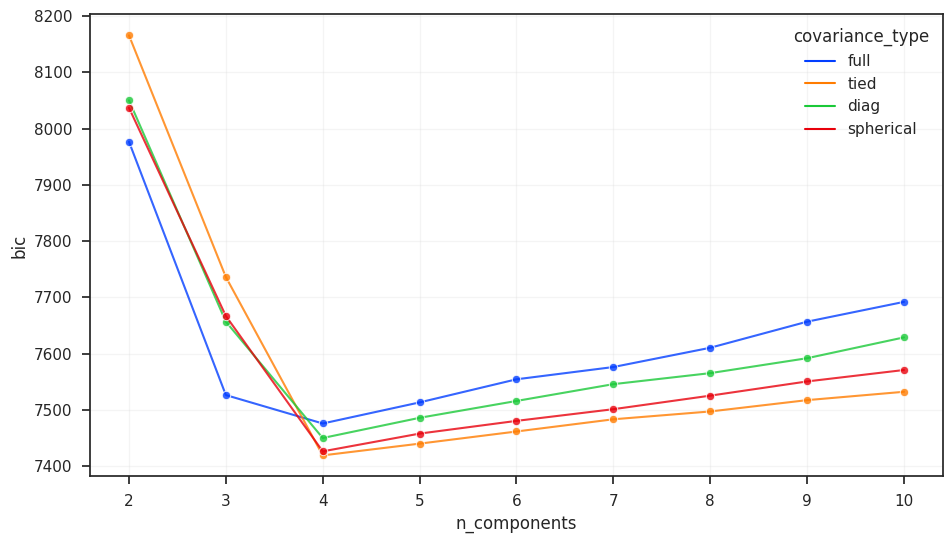

In [ ]:
# Plot
sns.lineplot(data=results, x='n_components', y='bic', hue='covariance_type', marker='o', alpha=.8);

# WorldCup Case

## Load dataset

In [ ]:
# Download and unzip files
!wget https://github.com/cmcouto-silva/datasets/raw/main/datasets/fifa-football-world-cup-dataset.zip
!unzip fifa-football-world-cup-dataset.zip

In [ ]:
# Listando arquivos com
files = glob.glob(r'FIFA - [1-2]*')
files

['FIFA - 1986.csv',
 'FIFA - 2018.csv',
 'FIFA - 1934.csv',
 'FIFA - 1966.csv',
 'FIFA - 1970.csv',
 'FIFA - 1994.csv',
 'FIFA - 1950.csv',
 'FIFA - 1990.csv',
 'FIFA - 2002.csv',
 'FIFA - 1982.csv',
 'FIFA - 2006.csv',
 'FIFA - 1930.csv',
 'FIFA - 2014.csv',
 'FIFA - 1962.csv',
 'FIFA - 1974.csv',
 'FIFA - 1978.csv',
 'FIFA - 1954.csv',
 'FIFA - 1938.csv',
 'FIFA - 1998.csv',
 'FIFA - 1958.csv',
 'FIFA - 2010.csv']

In [ ]:
def read_csv_custom(file):
  df = pd.read_csv(file)
  df['Year'] = int(re.search('\d+', file).group())
  return df

In [ ]:
df_teams = pd.concat([read_csv_custom(file) for file in files])
df_teams = df_teams.sort_values(['Year','Position'])
display(df_teams)

,Position,Team,Games Played,Win,Draw,Loss,Goals For,Goals Against,Goal Difference,Points,Year
0,1,Uruguay,4,4,0,0,15,3,12,8,1930
1,2,Argentina,5,4,0,1,18,9,9,8,1930
2,3,United States,3,2,0,1,7,6,1,4,1930
3,4,Yugoslavia,3,2,0,1,7,7,0,4,1930
4,5,Chile,3,2,0,1,5,3,2,4,1930
...,...,...,...,...,...,...,...,...,...,...,...
27,28,Costa Rica,3,0,1,2,2,5,−3,1,2018
28,29,Iceland,3,0,1,2,2,5,−3,1,2018
29,30,Morocco,3,0,1,2,2,4,−2,1,2018
30,31,Egypt,3,0,0,3,2,6,−4,0,2018


In [ ]:
df_teams.Year.value_counts()

2018    32
2014    32
2010    32
2006    32
2002    32
1998    32
1982    24
1994    24
1990    24
1986    24
1978    16
1934    16
1974    16
1970    16
1966    16
1962    16
1958    16
1954    16
1938    15
1950    13
1930    13
Name: Year, dtype: int64

## Prepare data

Adicionando novas colunas para que os dados fiquem comparáveis:

In [ ]:
df_teams = (
  df_teams
 .assign(**{
     'Win %': lambda x: x['Win'] / x['Games Played'],
     'Draw %': lambda x: x['Draw'] / x['Games Played'],
     'Loss %': lambda x: x['Loss'] / x['Games Played'],
     'Avg Goals For': lambda x: x['Goals For'] / x['Games Played'],
     'Avg Goals Against': lambda x: x['Goals Against'] / x['Games Played'],
 })
)

df_teams['Rank'] = df_teams.groupby('Year')['Position'].transform(lambda x: 1 - minmax_scale(x))
display(df_teams)

,Position,Team,Games Played,Win,Draw,Loss,Goals For,Goals Against,Goal Difference,Points,Year,Win %,Draw %,Loss %,Avg Goals For,Avg Goals Against,Rank
0,1,Uruguay,4,4,0,0,15,3,12,8,1930,1.000000,0.000000,0.000000,3.750000,0.750000,1.000000
1,2,Argentina,5,4,0,1,18,9,9,8,1930,0.800000,0.000000,0.200000,3.600000,1.800000,0.916667
2,3,United States,3,2,0,1,7,6,1,4,1930,0.666667,0.000000,0.333333,2.333333,2.000000,0.833333
3,4,Yugoslavia,3,2,0,1,7,7,0,4,1930,0.666667,0.000000,0.333333,2.333333,2.333333,0.750000
4,5,Chile,3,2,0,1,5,3,2,4,1930,0.666667,0.000000,0.333333,1.666667,1.000000,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,28,Costa Rica,3,0,1,2,2,5,−3,1,2018,0.000000,0.333333,0.666667,0.666667,1.666667,0.129032
28,29,Iceland,3,0,1,2,2,5,−3,1,2018,0.000000,0.333333,0.666667,0.666667,1.666667,0.096774
29,30,Morocco,3,0,1,2,2,4,−2,1,2018,0.000000,0.333333,0.666667,0.666667,1.333333,0.064516
30,31,Egypt,3,0,0,3,2,6,−4,0,2018,0.000000,0.000000,1.000000,0.666667,2.000000,0.032258


Agrupando os dados por time, considerando apeans aquelas com mais de 3 copas:

In [ ]:
df_teams_stats = df_teams.groupby(['Team']).agg(
  n_cups = ('Team', 'count'),
  avg_wins = ('Win %', 'mean'),
  avg_draws = ('Draw %', 'mean'),
  avg_losses = ('Loss %', 'mean'),
  avg_goals_for = ('Avg Goals For', 'mean'),
  avg_goals_against = ('Avg Goals Against', 'mean'),
  avg_rank = ('Rank', 'mean')
)

df_teams_stats = df_teams_stats.query('n_cups > 3')
display(df_teams_stats)

,n_cups,avg_wins,avg_draws,avg_losses,avg_goals_for,avg_goals_against,avg_rank
Team,,,,,,,
Algeria,4,0.229167,0.229167,0.541667,0.937500,1.437500,0.318724
Argentina,17,0.481653,0.173950,0.344398,1.670588,1.322269,0.699798
Australia,5,0.116667,0.250000,0.633333,0.783333,1.966667,0.246022
Austria,7,0.361905,0.171429,0.466667,1.378571,1.611905,0.511454
Belgium,13,0.302015,0.191209,0.506777,1.356410,1.924359,0.494288
Brazil,21,0.626871,0.145805,0.227324,2.073016,1.079138,0.803850
Bulgaria,6,0.071429,0.329365,0.599206,0.599206,2.011905,0.292941
Cameroon,7,0.133333,0.333333,0.533333,0.723810,1.876190,0.253657
Chile,9,0.296296,0.222222,0.481481,1.166667,1.509259,0.494966


Verificando outliers:

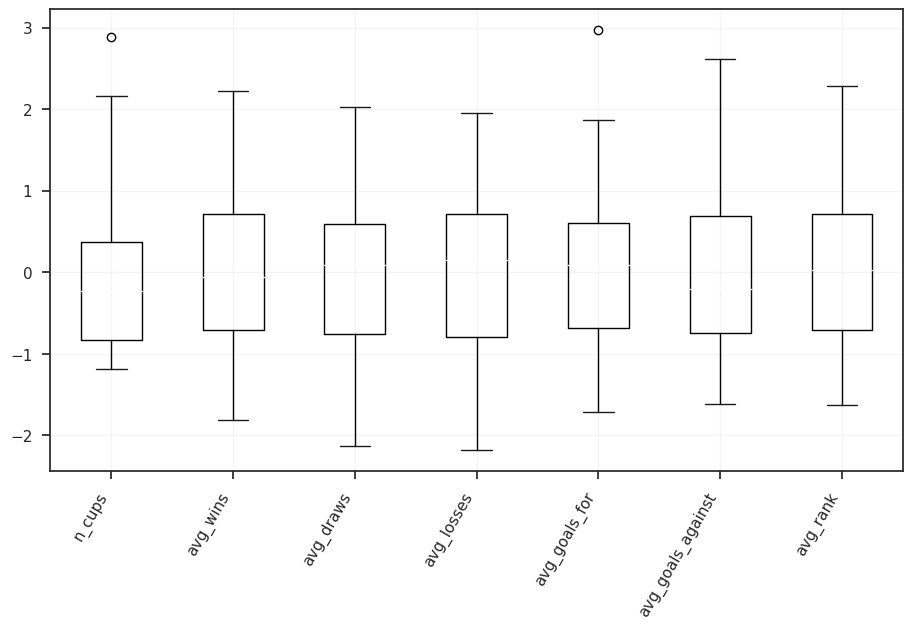

In [ ]:
df_teams_stats.apply(scale).boxplot()
plt.xticks(rotation=60, ha='right')
plt.show()

Limitando outliers para no máximo 3 desvios padrões:

In [ ]:
for col in df_teams_stats.columns:
  avg,std = df_teams_stats[col].agg(['mean','std'])
  df_teams_stats[col] = df_teams_stats[col].clip(lower=avg-3*std, upper=avg+3*std) # capping | clipping

Normalizando valores para para uma mesma escala (menor valor será -1 e maior 1):

In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))

X = df_teams_stats.copy()
X[:] = scaler.fit_transform(X)

print('Scaled dataset')
display(X.head())

print('\nDataset stats')
display(X.describe())

Scaled dataset


,n_cups,avg_wins,avg_draws,avg_losses,avg_goals_for,avg_goals_against,avg_rank
Team,,,,,,,
Algeria,-1.000000,-0.432027,0.124881,0.371158,-0.655463,-0.414571,-0.684617
Argentina,0.529412,0.477108,-0.329910,-0.412321,0.091155,-0.567985,0.463290
Australia,-0.882353,-0.837110,0.296473,0.735225,-0.812475,0.289941,-0.903618
Austria,-0.647059,0.045928,-0.350674,0.073286,-0.206251,-0.182375,-0.104057
Belgium,0.058824,-0.169721,-0.187756,0.232588,-0.228821,0.233614,-0.155766



Dataset stats


,n_cups,avg_wins,avg_draws,avg_losses,avg_goals_for,avg_goals_against,avg_rank
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000
mean,-0.417237,-0.103023,0.025020,0.056418,-0.268521,-0.233616,-0.166546
std,0.497119,0.502087,0.486581,0.489534,0.432345,0.477895,0.517398
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.823529,-0.457532,-0.340292,-0.328823,-0.561574,-0.583760,-0.526944
50%,-0.529412,-0.134109,0.067684,0.130024,-0.228821,-0.328455,-0.153722
75%,-0.235294,0.253766,0.310200,0.398739,-0.012108,0.094495,0.199024
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Modeling

### Clusterização hierárquica

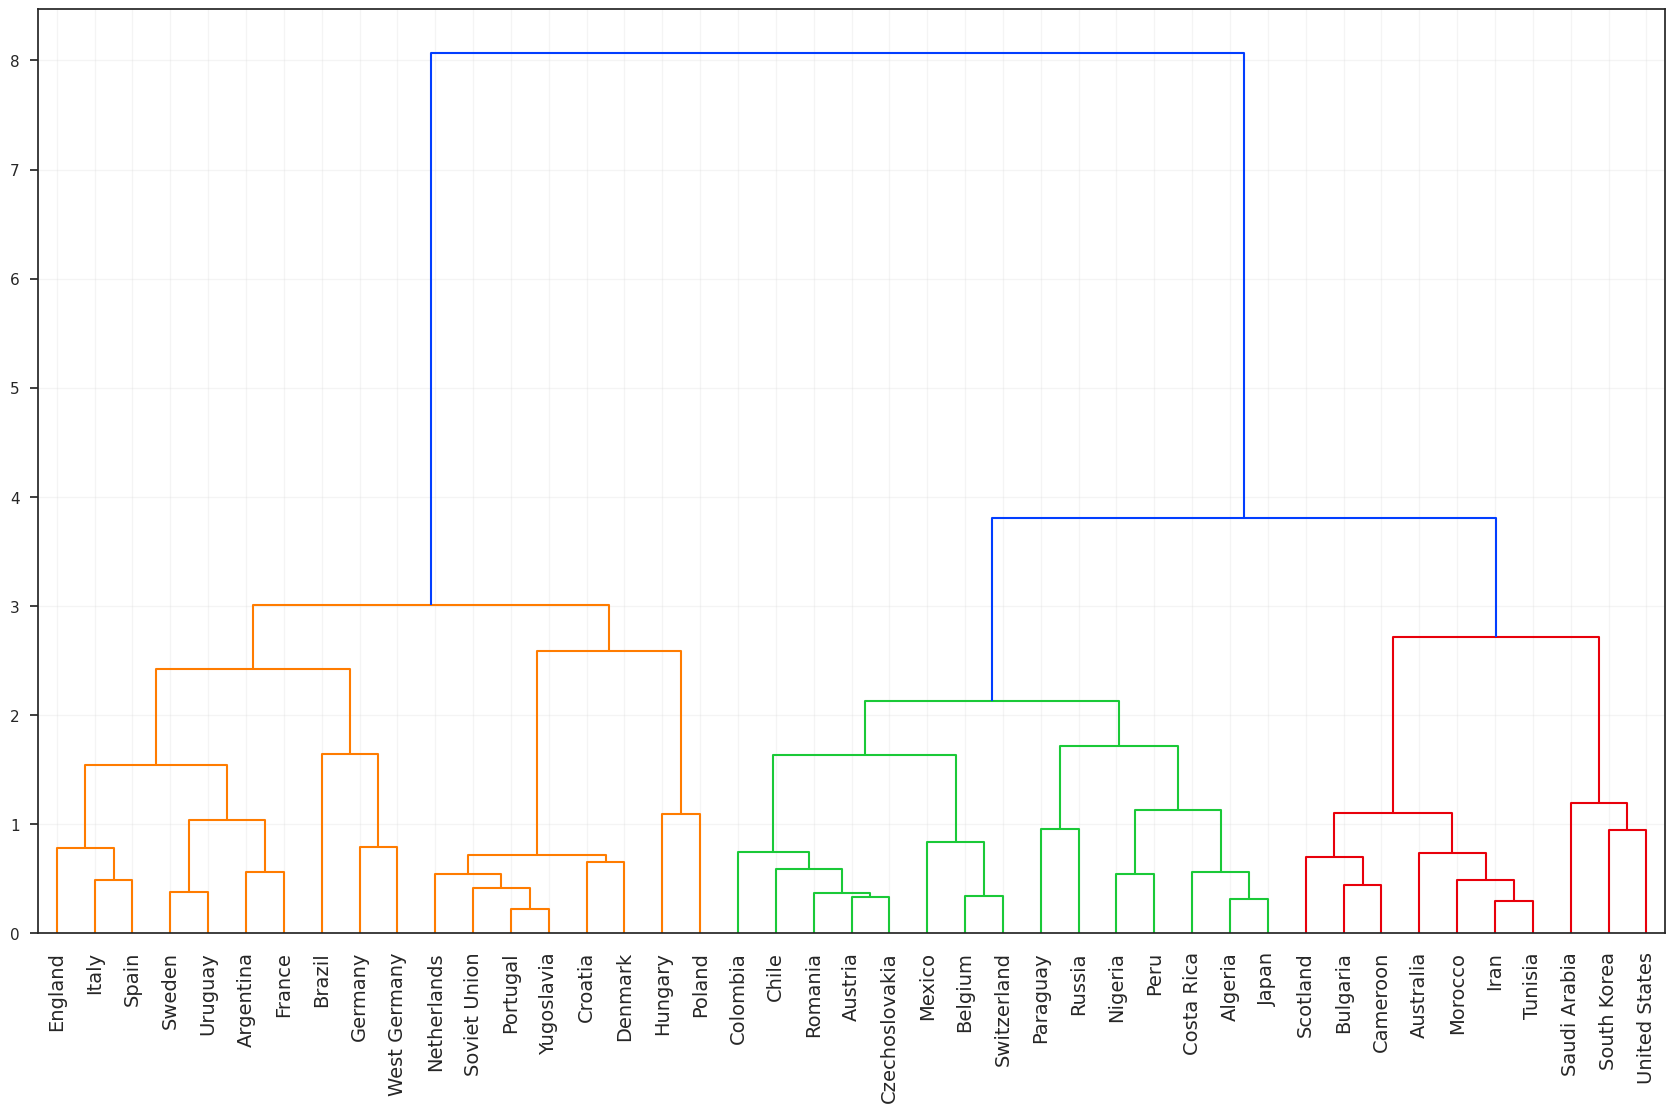

In [ ]:
plt.figure(figsize=(21,12))
Z = linkage(X, method='ward')
dendrogram_dict = dendrogram(Z, labels=X.index, color_threshold=3.5)
plt.xticks(fontsize=14)
plt.show()

In [ ]:
@interact(metric=['distortion','silhouette','calinski_harabasz'])
def kplot(metric):
  kelbow_visualizer(AgglomerativeClustering(), X, timings=False, metric=metric)
  plt.show()

interactive(children=(Dropdown(description='metric', options=('distortion', 'silhouette', 'calinski_harabasz')…

In [ ]:
labels = fcluster(Z, 3, criterion='maxclust')

(
  df_teams_stats.assign(cluster=labels)
  .groupby('cluster')
  .mean()
  .transpose()
  .style.background_gradient(cmap='Reds', axis=1)
)

cluster,1,2,3
n_cups,11.333333,7.666667,6.600000
avg_wins,0.454063,0.281492,0.138762
avg_draws,0.198561,0.212052,0.257794
avg_losses,0.347376,0.506455,0.603444
avg_goals_for,1.684505,1.210072,0.817730
avg_goals_against,1.312465,1.624584,1.966381
avg_rank,0.656229,0.440333,0.268338


In [ ]:
df_teams_stats.assign(cluster=labels)

,n_cups,avg_wins,avg_draws,avg_losses,avg_goals_for,avg_goals_against,avg_rank,cluster
Team,,,,,,,,
Algeria,4,0.229167,0.229167,0.541667,0.937500,1.437500,0.318724,2
Argentina,17,0.481653,0.173950,0.344398,1.670588,1.322269,0.699798,1
Australia,5,0.116667,0.250000,0.633333,0.783333,1.966667,0.246022,3
Austria,7,0.361905,0.171429,0.466667,1.378571,1.611905,0.511454,2
Belgium,13,0.302015,0.191209,0.506777,1.356410,1.924359,0.494288,2
Brazil,21,0.626871,0.145805,0.227324,2.073016,1.079138,0.803850,1
Bulgaria,6,0.071429,0.329365,0.599206,0.599206,2.011905,0.292941,3
Cameroon,7,0.133333,0.333333,0.533333,0.723810,1.876190,0.253657,3
Chile,9,0.296296,0.222222,0.481481,1.166667,1.509259,0.494966,2


### K-Means

In [ ]:
@interact(metric=['distortion','silhouette','calinski_harabasz'])
def kplot(metric):
  kelbow_visualizer(KMeans(), X, timings=False, metric=metric)
  plt.show()

interactive(children=(Dropdown(description='metric', options=('distortion', 'silhouette', 'calinski_harabasz')…

In [ ]:
cluster_metrics_results = []
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score

for k in range(2,11):
  model = AgglomerativeClustering(n_clusters=k)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k':k}
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient(cmap='Blues')

,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,
2,0.368980,0.993267,35.907706
3,0.257579,1.228334,26.588649
4,0.214824,1.370638,22.682177
5,0.229907,1.213146,20.994163
6,0.241293,0.997507,20.683770
7,0.267706,0.963538,21.098088
8,0.274891,1.090488,21.464240
9,0.283312,0.984589,21.081693
10,0.289108,0.872702,21.048308


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



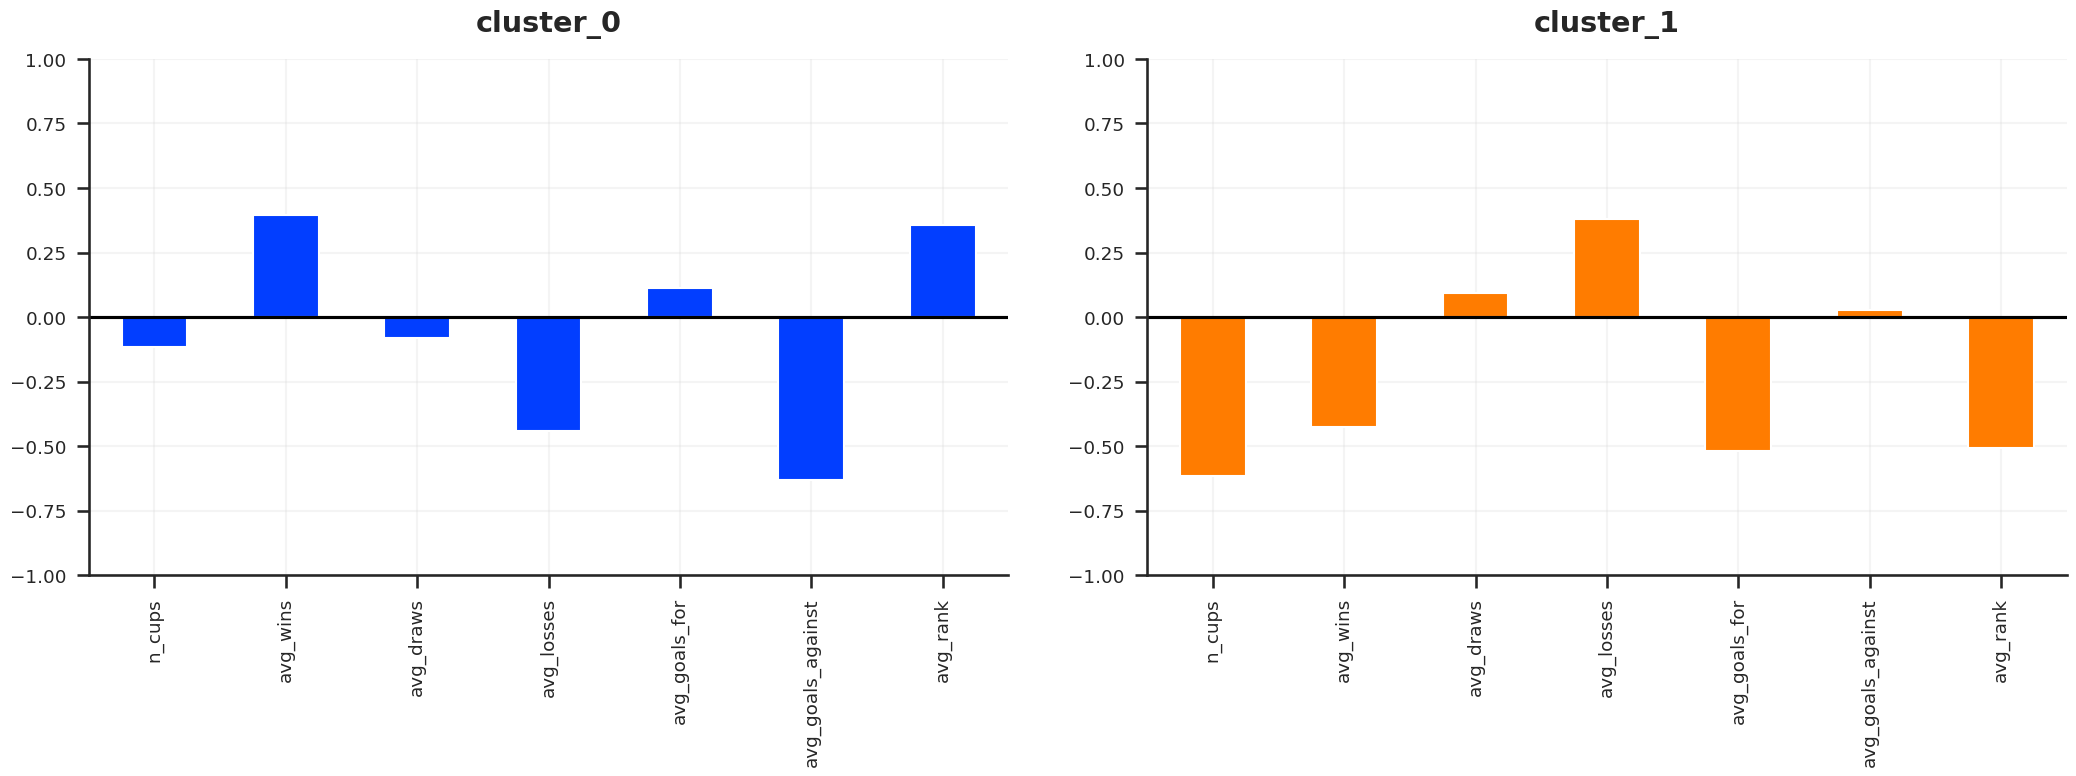

In [ ]:
# Treinando modelo e capturando clusters
model = KMeans(n_clusters=2, random_state=2023)
labels = model.fit_predict(X)

# Interpretando cluster via centroides
axes = (
  pd.DataFrame(model.cluster_centers_, columns=X.columns)
  .T
 .add_prefix('cluster_')
 .plot.bar(subplots=True, legend=False, ylim=(-1,1), figsize=(21,8), layout=(1,2))
)

for ax in axes[0]:
  ax.axhline(y=0, color='black')

plt.tight_layout(w_pad=3)
sns.despine()
plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



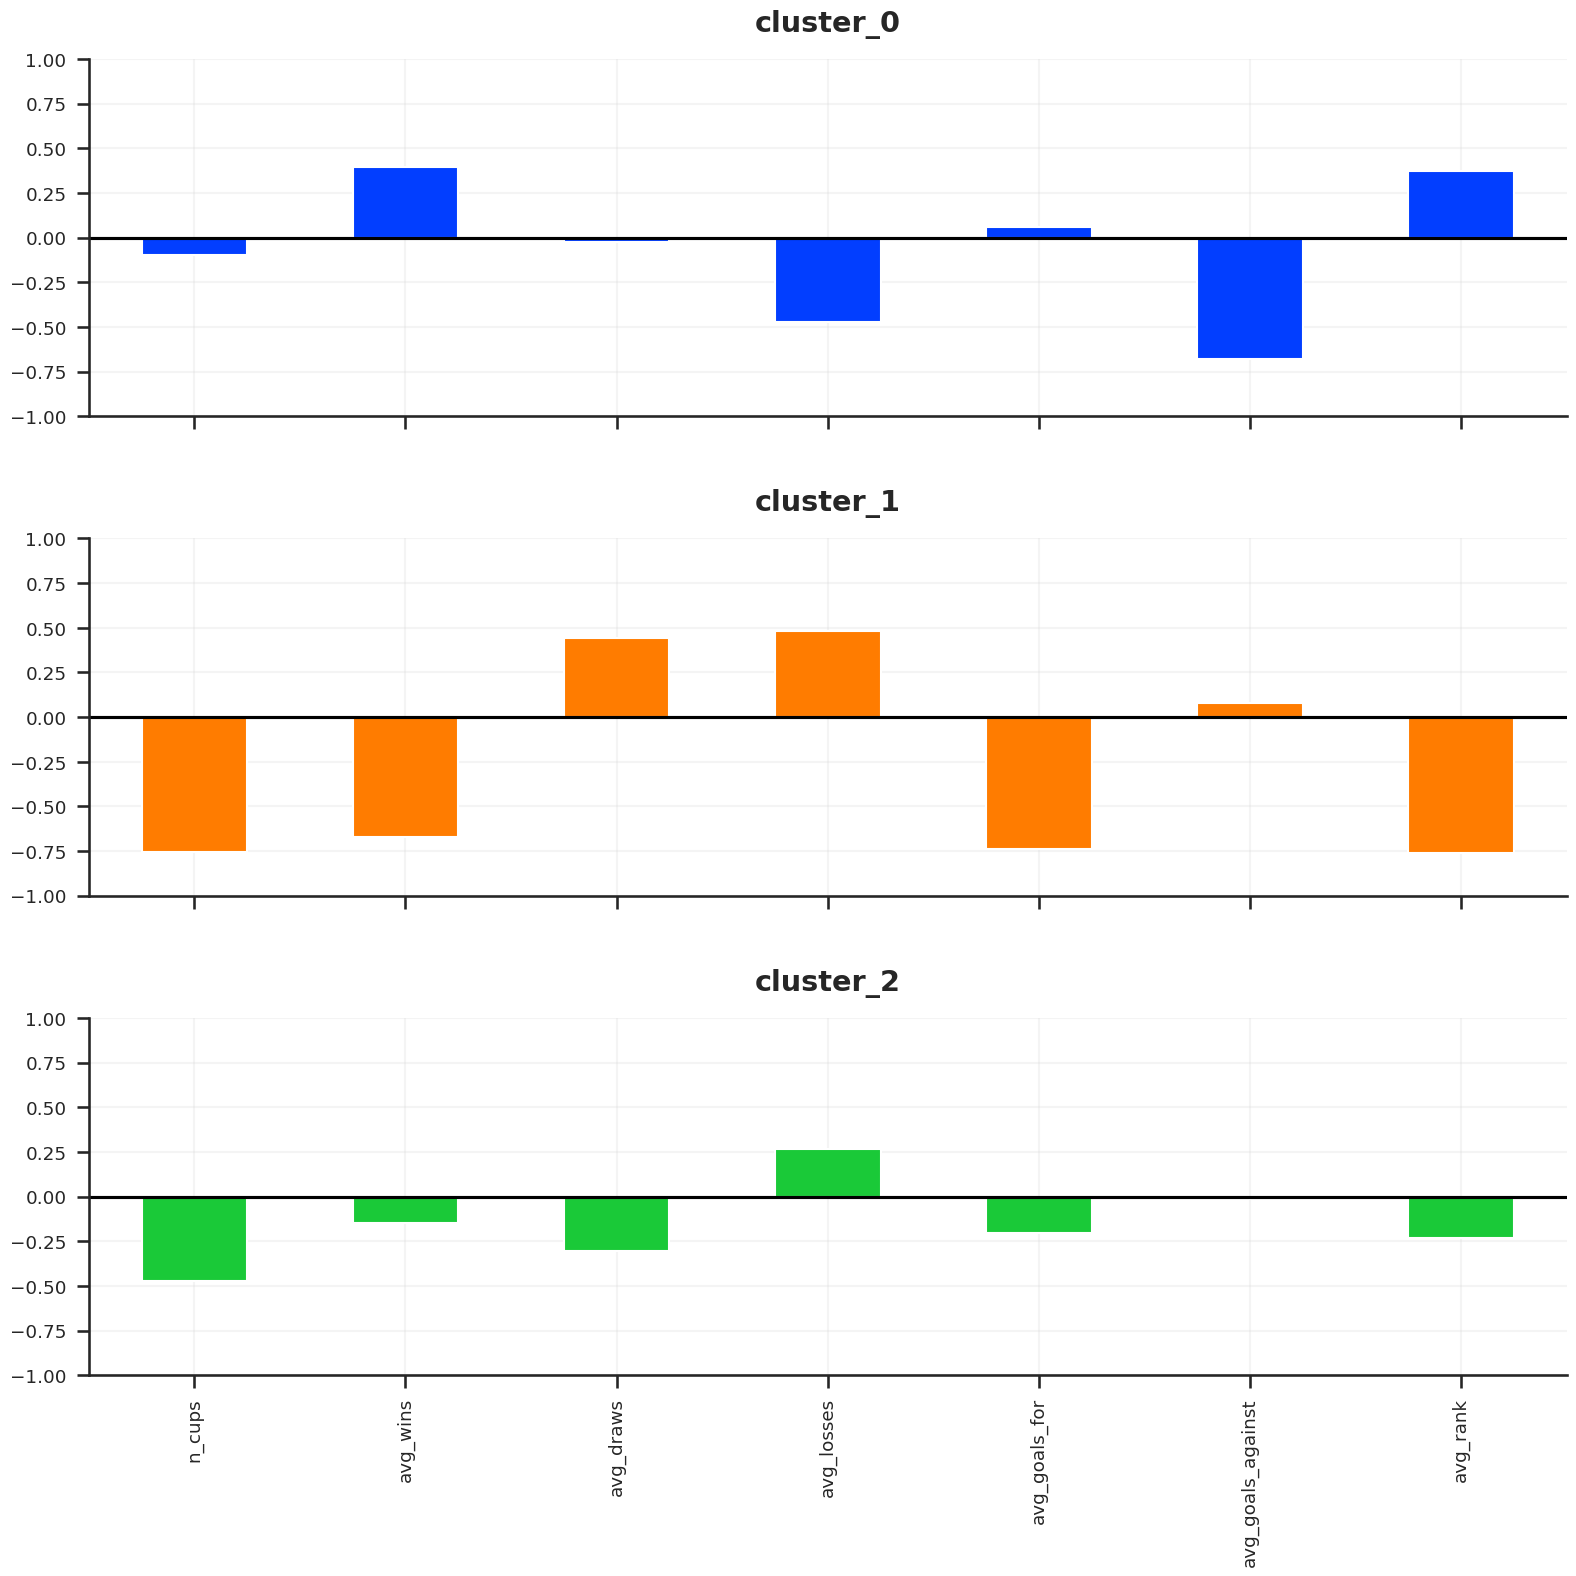

In [ ]:
# Treinando modelo e capturando clusters
model = KMeans(n_clusters=3, random_state=2023)
labels = model.fit_predict(X)

# Interpretando cluster via centroides
axes = (
  pd.DataFrame(model.cluster_centers_, columns=X.columns)
  .T
 .add_prefix('cluster_')
 .plot.bar(subplots=True, figsize=(16,16), legend=False, ylim=(-1,1))
)

for ax in axes:
  ax.axhline(y=0, color='black')

plt.tight_layout(h_pad=3)
sns.despine()
plt.show()

# Wine dataset

## Carregando dados

In [ ]:
df_wines,_ = datasets.load_wine(as_frame=True, return_X_y=True)
df_wines

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


## Data cleaning

Há dados duplicados?

In [ ]:
df_wines.duplicated().sum()

0

Há dados faltantes?

In [ ]:
df_wines.isna().sum().sum()

0

Há outliers?

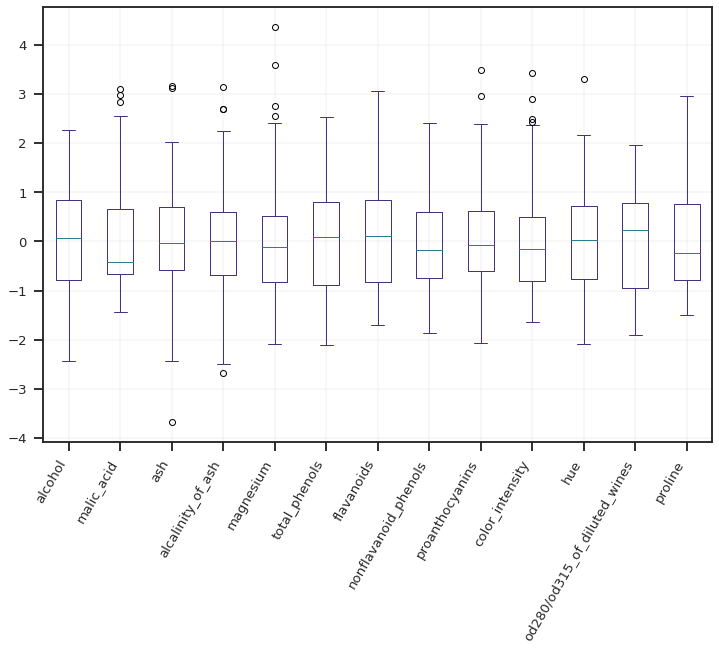

In [ ]:
# Scaling
df_wines_scaled = df_wines.apply(scale)
# Plot
df_wines_scaled.plot.box()
plt.xticks(rotation=60, ha='right');

Identificando e removendo linhas com outliers (|Z-score| > 3):

In [ ]:
outlier_rows = (df_wines_scaled.abs()>3).any(axis=1)
outlier_rows.sum()

10

In [ ]:
df_wines_scaled = df_wines_scaled[~outlier_rows]

In [ ]:
df_wines_scaled.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


## Verificando melhor K

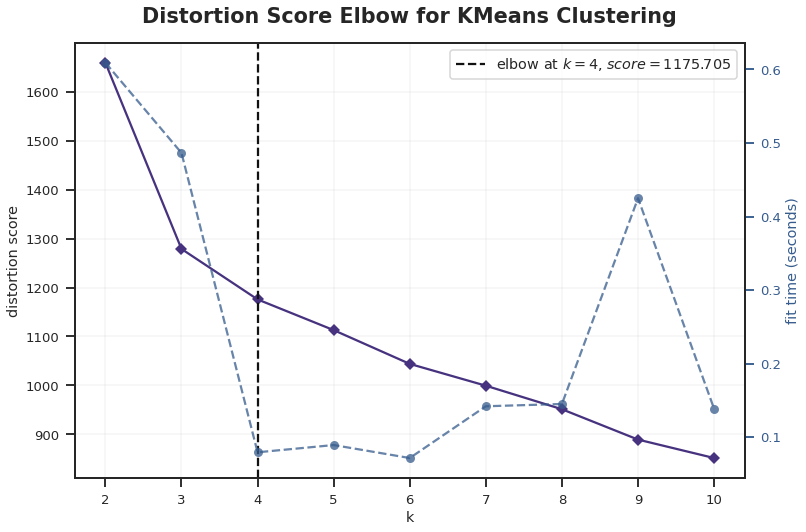

In [ ]:
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(2,11))
visualizer.fit(df_wines_scaled).show();

## Clusterizando

Criando e treinando modelo

In [ ]:
kmeans = KMeans(4, random_state=0).fit(df_wines_scaled)

Salvando centroides e labels

In [ ]:
centroids = kmeans.cluster_centers_
labels = kmeans.predict(df_wines_scaled)

## Interpretando clusters

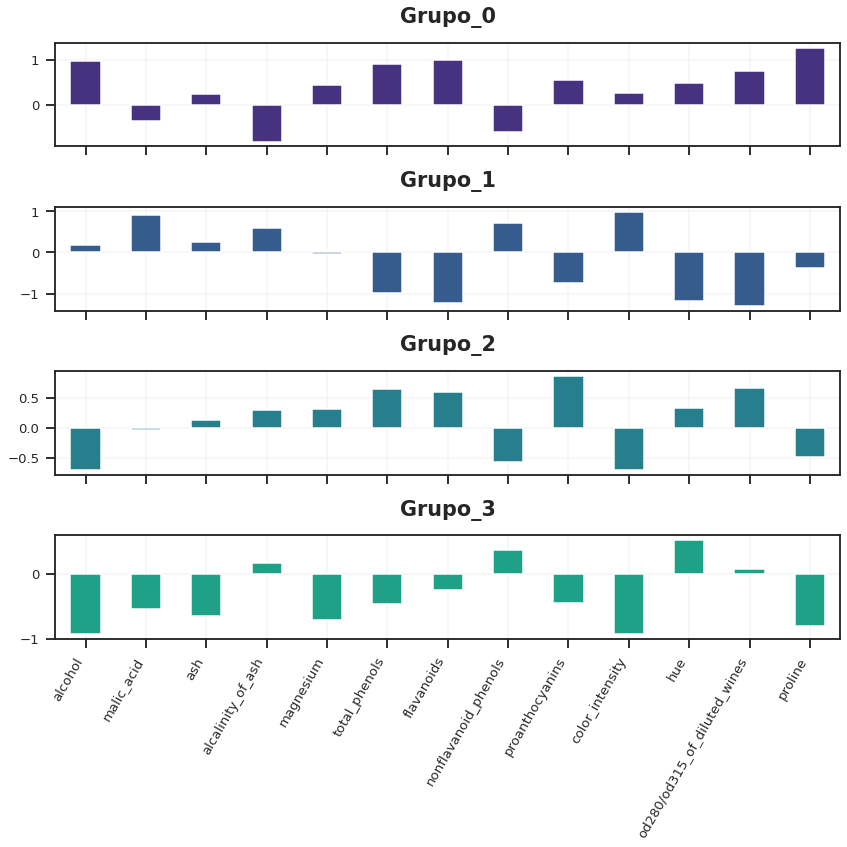

In [ ]:
pd.DataFrame(centroids, columns=df_wines.columns).T.add_prefix('Grupo_').plot.bar(subplots=True, figsize=(12,12), legend=False)
plt.xticks(rotation=60, ha='right')
plt.tight_layout();

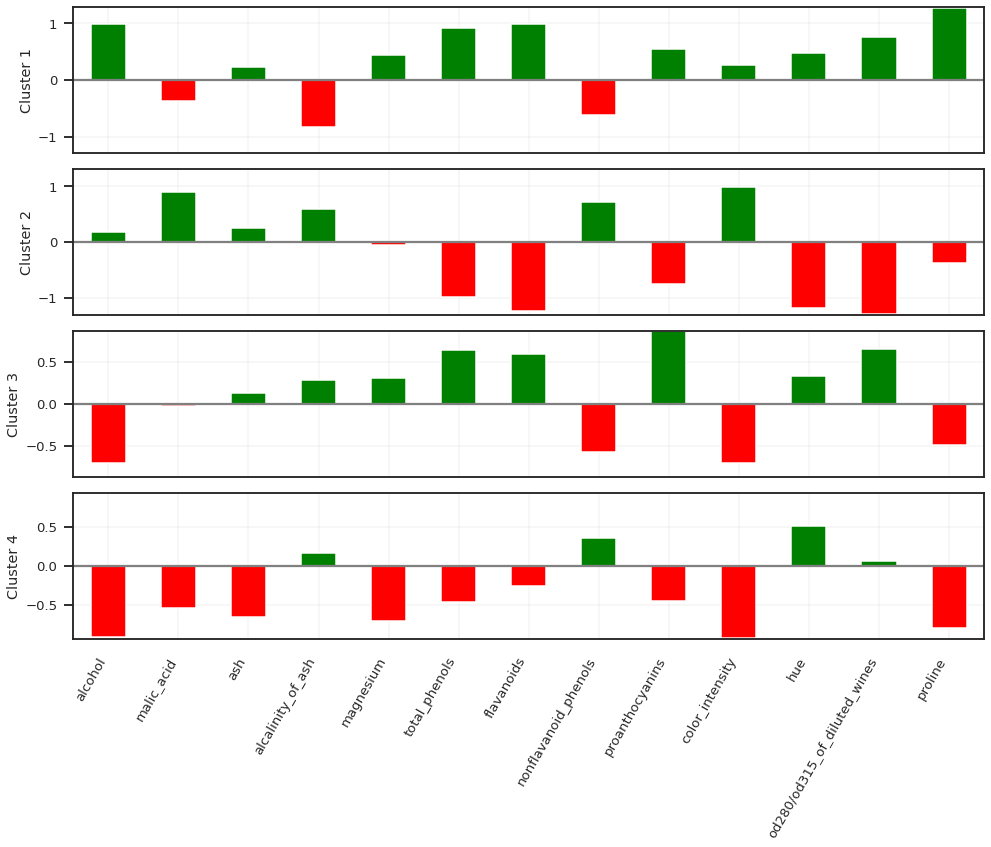

In [ ]:
# Adaptado do livro "Practical Statistics for Data Scientists"
fig,axes = plt.subplots(nrows=4, figsize=(14,12), sharex=True)

for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i+1}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none') 

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
(
    df_wines[~outlier_rows].assign(cluster=labels)
    .groupby('cluster')
    .agg(['mean','min','median','max'])
)

alcohol                       malic_acid                     \
              mean    min  median    max       mean   min median   max   
cluster                                                                  
0        13.795926  12.85  13.795  14.83   1.933333  1.35  1.740  4.04   
1        13.126875  12.20  13.135  14.16   3.379167  1.24  3.285  5.65   
2        12.444583  11.45  12.370  13.86   2.222500  0.89  1.900  4.43   
3        12.281905  11.41  12.195  13.67   1.756667  0.74  1.610  4.30   

              ash        ...    hue       od280/od315_of_diluted_wines        \
             mean   min  ... median   max                         mean   min   
cluster                  ...                                                   
0        2.430370  2.04  ...   1.07  1.28                     3.145185  2.51   
1        2.429167  2.10  ...   0.67  0.96                     1.684583  1.27   
2        2.395000  1.70  ...   1.04  1.42                     3.055000  2.26   
3        2.207381  1.70  ...   1.03  1.45                     2.671667  1.59   

                          proline                         
        median   max         mean    min  median     max  
cluster                                                   
0        3.135  4.00  1147.537037  760.0  1112.5  1680.0  
1        1.660  2.47   626.875000  415.0   622.5   880.0  
2        3.125  3.82   564.125000  290.0   572.5   886.0  
3        2.730  3.57   497.309524  278.0   484.0   870.0  

[4 rows x 52 columns]

In [ ]:
(
    df_wines[~outlier_rows].assign(cluster=labels)
    .groupby('cluster')
    .mean()
    .transpose()
    .style.background_gradient(axis=1, cmap='YlOrRd')
)

cluster,0,1,2,3
alcohol,13.795926,13.126875,12.444583,12.281905
malic_acid,1.933333,3.379167,2.222500,1.756667
ash,2.430370,2.429167,2.395000,2.207381
alcalinity_of_ash,16.724074,21.364583,19.741667,20.245238
magnesium,106.129630,99.041667,97.500000,89.761905
total_phenols,2.862222,1.654792,2.674167,1.996667
flavanoids,3.017407,0.787292,2.574167,1.790952
nonflavanoid_phenols,0.285185,0.449167,0.287083,0.406667
proanthocyanins,1.907778,1.131042,1.974167,1.339048
color_intensity,5.664630,7.225417,3.449167,2.955238


# Dataset with mix data

**Clustering com dados categóricos:**
- kmodes (apenas dados categóricos)
- kprototypes (dados numéricos e categóricos)
- hierarquical clustering com Glower' distance

**Análises de associação / redução de dimensionalidade:**
- Análise de correspondência simples (CA) - apenas dados categóricos com 2 variáveis
- Análise de correspondência múltipla (MCA) - apenas dados categóricos com 2 ou mais variáveis
- FAMD - dados mistos

## Dados categóricos

In [ ]:
from yellowbrick.datasets import load_mushroom

In [ ]:
df_mushroom = load_mushroom()[0]
df_mushroom

,shape,surface,color
0,convex,smooth,yellow
1,bell,smooth,white
2,convex,scaly,white
3,convex,smooth,gray
4,convex,scaly,yellow
...,...,...,...
8118,knobbed,smooth,brown
8119,convex,smooth,brown
8120,flat,smooth,brown
8121,knobbed,scaly,brown


In [ ]:
kmodes_model = KModes(n_clusters=3)
labels = kmodes_model.fit_predict(df_mushroom)
print(labels)
print(kmodes_model.cost_)

[0 1 0 ... 1 0 0]
10343.0


In [ ]:
custos = [KModes(n_clusters=k).fit(df_mushroom).cost_ for k in range(2,11)]

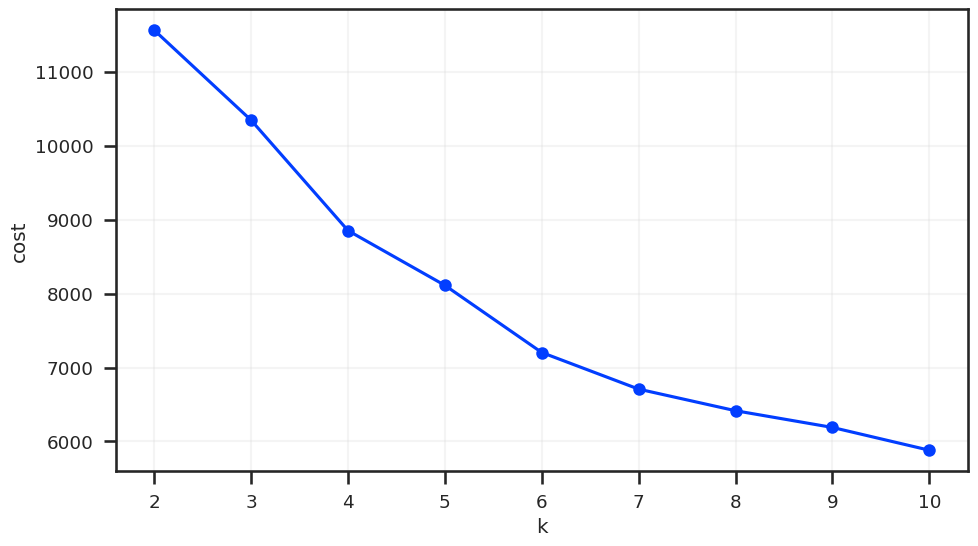

In [ ]:
ax = pd.Series(custos, index=range(2,11)).plot(marker='o')
ax.set(xlabel='k', ylabel='cost');

## Dados mistos

In [ ]:
df_diabetes = pd.read_csv('https://raw.githubusercontent.com/Ekeany/Clustering-Mixed-Data/main/data/heart.csv')
df_diabetes = df_diabetes.drop(columns='target')
df_diabetes

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3


In [ ]:
# Padroniza dados numéricos
numerical_columns = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
df_diabetes[numerical_columns] = df_diabetes[numerical_columns].apply(scale)

In [ ]:
# Define posições dos dados categóricos
categorical_columns = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
categorical_idx = df_diabetes.columns.isin(categorical_columns).nonzero()[0].tolist()

In [ ]:
# Modelo
kproto_model = KPrototypes()
kproto_model.fit_predict(df_diabetes, categorical=categorical_idx)

array([3, 3, 5, 6, 0, 2, 0, 5, 2, 2, 2, 6, 6, 7, 2, 5, 0, 7, 5, 2, 2, 5,
       5, 2, 5, 2, 2, 7, 0, 2, 5, 7, 5, 6, 1, 5, 6, 2, 2, 0, 0, 6, 3, 6,
       6, 6, 5, 6, 7, 6, 6, 6, 1, 5, 2, 2, 5, 6, 5, 6, 7, 6, 5, 5, 2, 5,
       5, 5, 5, 2, 6, 5, 5, 6, 5, 6, 3, 2, 5, 6, 5, 6, 6, 2, 6, 0, 2, 5,
       5, 7, 5, 2, 2, 6, 5, 7, 0, 6, 6, 6, 5, 4, 2, 5, 5, 7, 4, 6, 6, 6,
       4, 2, 0, 5, 6, 5, 5, 3, 5, 6, 1, 6, 5, 6, 5, 5, 5, 2, 5, 7, 2, 6,
       6, 5, 6, 6, 7, 7, 7, 1, 6, 6, 5, 7, 7, 2, 5, 2, 5, 5, 4, 7, 4, 2,
       5, 7, 5, 5, 7, 6, 6, 0, 5, 5, 5, 4, 1, 3, 1, 3, 1, 5, 6, 3, 1, 1,
       6, 0, 3, 1, 1, 7, 0, 3, 3, 6, 1, 1, 2, 5, 1, 1, 7, 1, 3, 4, 3, 2,
       1, 6, 5, 1, 1, 4, 3, 6, 1, 3, 3, 2, 6, 3, 5, 4, 1, 1, 1, 1, 1, 6,
       0, 3, 2, 4, 1, 7, 1, 5, 4, 1, 5, 4, 4, 1, 1, 6, 6, 6, 0, 6, 4, 4,
       1, 1, 1, 6, 0, 4, 4, 1, 3, 6, 1, 1, 4, 6, 1, 1, 2, 3, 4, 6, 1, 6,
       7, 7, 4, 7, 1, 1, 6, 3, 7, 6, 1, 5, 1, 6, 0, 3, 1, 5, 1, 5, 1, 1,
       2, 2, 1, 1, 2, 3, 4, 2, 3, 3, 7, 7, 7, 6, 3,

In [ ]:
# custo
kproto_model.cost_

1066.1191983275144